In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k


from geo_tool import Point_Cloud

from tf_lab.nips.data_sets.shape_net import pc_loader as sn_pc_loader
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.point_net_aae import PointNetAdversarialAutoEncoder


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, \
                                     sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

from tf_lab.icml.ae_farm_helper import relevant_class

In [3]:
from bench_pc_gan.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import pclouds_centered_and_half_sphere
from general_tools.simpletons import iterate_in_chunks

PyTorch not working. MMD measurement won't be available


In [78]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
class_name = raw_input('Give me the class type: ').lower()
n_pc_samples = 2048
ae_loss = 'emd'

syn_id = shape_net_category_to_synth_id()[class_name]
bneck_size = int(raw_input('Give me the AE bneck size:'))

# experiment_name = 'aee_' + class_name + '_conv_arch_bneck_' + str(bneck_size) + '_2048pts_' + ae_loss

experiment_name = 'aee_fast' + class_name + '_conv_arch_bneck_' + str(bneck_size) + '_2048pts_' + ae_loss

train_dir = osp.join(top_data_dir, 'OUT/models/nips/adversarial_ae', experiment_name)

Give me the class type: chair
Give me the AE bneck size:16


In [12]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )
train_data = PointCloudDataSet(pclouds)

6778 files containing complete point clouds were found.


In [13]:
conf = Conf.load(osp.join(train_dir, 'configuration'))
print conf
discriminator = latent_code_discriminator_two_layers
noise_dim = bneck_size
reset_tf_graph()
aae = PointNetAdversarialAutoEncoder(experiment_name, conf, noise_dim, discriminator)

                    batch_size: 50
                      beta_adv: 0
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'layer_sizes': [1024, 2048, 6144]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {'filter_sizes': [40, 20, 10, 10], 'n_filters': [128, 128, 256, 16], 'strides': [1, 2, 2, 1]}
               experiment_name: aee_fastchair_conv_arch_bneck_16_2048pts_emd
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: emd
             loss_display_step: 1
                        lr_adv: 1e-05
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                 

In [14]:
saved_epochs = read_saved_epochs(conf.train_dir)
load_epoch = saved_epochs[-1]
aae.restore_model(conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 1000.


In [15]:
_, latent_codes, _ = latent_embedding_of_entire_dataset(train_data, aae, conf)
reconstructed = []
for b in iterate_in_chunks(latent_codes, conf.batch_size):
    reconstructed.append(aae.decode(b))
reconstructed = np.vstack(reconstructed) 
reconstructed = pclouds_centered_and_half_sphere(reconstructed)

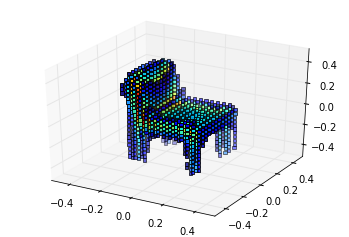

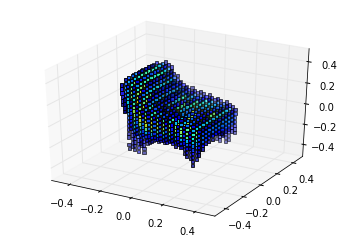

In [71]:
cmp_in_sphere = False
voxel_resolution = 28
pclouds_ = pclouds_centered_and_half_sphere(pclouds)
_, gt_grid_var = entropy_of_occupancy_grid(pclouds_, voxel_resolution, in_sphere=cmp_in_sphere)
_, sample_grid_var = entropy_of_occupancy_grid(reconstructed, voxel_resolution, in_sphere=cmp_in_sphere)

plot_probability_space_on_voxels(voxel_resolution, 0.3, gt_grid_var)

plot_probability_space_on_voxels(voxel_resolution, 0.3, sample_grid_var)

In [157]:
jsd_epoch = jensen_shannon_divergence(sample_grid_var, gt_grid_var)
print 'JSD of training data: ', jsd_epoch

In [49]:
noise = np.random.normal(0, 1, (train_data.num_examples, aae.bottleneck_size))
posterior = pclouds_centered_and_half_sphere(aae.decode(noise))
_, sample_grid_var = entropy_of_occupancy_grid(posterior, voxel_resolution, in_sphere=cmp_in_sphere)
# jsd_epoch = jensen_shannon_divergence(sample_grid_var, gt_grid_var)
# print 'JSD of synthetic data: ', jsd_epoch

In [12]:
from sklearn import mixture

for n_component in [10]:
    print n_component
    gmm = mixture.GaussianMixture(n_component, covariance_type='full')
    gmm.fit(latent_codes)
#     sample_codes = gmm.sample(raw_data.num_examples)[0]
    print gmm.bic(latent_codes)    
    print gmm.score(latent_codes)

10
-133111.670444
10.814373573


In [ ]:
# At 1K Epochs AAE learns an embedding with JSD of:
# bneck - JSD
# 32: 0.00075
# 16: 

# At 1K Epochs AAE learns to generate synthetic samples with JSD of:
# bneck - JSD 
# 32: 0.01545, 0.01583, 0.01595
# 16: 